In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import xarray as xa
import scipy.stats as stats
from scipy.special import loggamma
from statsmodels.sandbox.distributions.mv_normal import MVT
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import wraps
from cycler import cycler
from itertools import cycle
# from fastcache import lru_cache
import inspect
import gsum
from gsum import rbf, default_attributes, cholesky_errors, mahalanobis, lazy_property, pivoted_cholesky
from gsum import ConjugateGaussianProcess, ConjugateStudentProcess, Diagnostic, GraphicalDiagnostic

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

%load_ext Cython
%matplotlib inline

In [2]:
mpl.rcParams['figure.dpi'] = 120

In [3]:
nn = 10
a = np.random.randn(nn, nn)
aa = a.T @ a + np.eye(nn)
y = np.random.randn(nn)
mean = np.ones(nn)
chol_aa = np.linalg.cholesky(aa)
pinv_aa = np.linalg.pinv(aa)
chol_md = mahalanobis(y, mean, chol=chol_aa)
pinv_md = mahalanobis(y, mean, inv=pinv_aa)
print(np.allclose(pinv_md, chol_md))
print(pinv_md, chol_md)

True
3.71618405902383 3.7161840590238304


# B&O Model Checking Implementation

Bastos & O'Hagan provided a great set of diagnostic tools for testing whether or not a Gaussian process (GP) is a reasonable emulator for an expensive simulator. Our use case is slightly different than theirs. We don't necessarily care about our GPs matching some underlying simulator. Rather, given a set of curves from a hierarchy of simulators, we wish to answer the following questions:
1. Can they reasonably be assumed to be drawn from the same underlying Gaussian process?
2. If so, which Gaussian process?
3. The underlying GP is later used as a model discrepancy, so how can we test its performance against experiment?

These three questions may or may not be decided by diagnostics discussed in B&O, but to find out we must implement their methods!
That is what this notebook aims to do.

## Model Checking for GPs (Source Code)


Python has no pivoted cholesky decomposition, so I made one myself from `gsl`.
Prove that the pivoted cholesky I wrote works:

In [4]:
np.random.seed(1)
# m = np.ones((4, 4)) + 2 * np.eye(4)
r = np.random.rand(4, 4)
m = r + r.T + 2 * np.eye(4)
G_pc = pivoted_cholesky(m)

# print('R\n', pc, '\n\nP\n', pp, '\n')
# G = pp @ pc
print('M original\n', m, '\n')
print('G\n', G_pc, '\n')
# print(G @ G.T)
print('G.G^T = M?', np.allclose(G_pc @ G_pc.T, m))

M original
 [[2.83404401 0.86708038 0.39688185 0.50678482]
 [0.86708038 2.18467719 0.72507695 1.22367816]
 [0.39688185 0.72507695 2.83838903 0.71260709]
 [0.50678482 1.22367816 0.71260709 3.34093502]] 

G
 [[0.27726151 1.66047284 0.         0.        ]
 [0.6694732  0.41040191 0.24095152 1.22881873]
 [0.38986669 0.17391843 1.6297685  0.        ]
 [1.82782248 0.         0.         0.        ]] 

G.G^T = M? True


Here I am just testing two different equations for the posterior scale parameter. Ignore unless you're into that sort of thing.

In [5]:
def scale_test(y, R, m0=0, v0=1, a0=1, b0=1):
    y = np.atleast_2d(y)
    N = y.shape[-1]
    ny = y.shape[0]
    print(ny, N)
    avg_y = np.average(y, axis=0)
    one = np.ones(N, dtype=np.float64)
    cholR = np.linalg.cholesky(R)
    
    a = a0 + N*ny / 2.
    v = (1./v0 + ny * mahalanobis(one, 0., cholR)**2)**(-1)
    m = v * (m0 / v0 + ny * one @ np.linalg.solve(R, avg_y))
    b = b0 + 0.5 * (m0**2 / v0 - m**2 / v + np.sum(mahalanobis(y, 0, cholR)**2))
    
    R2 = R / ny + one * v0 * one[:, None]
    chol2 = np.linalg.cholesky(R2)
    b_test = b0 + 0.5 * (mahalanobis(avg_y, m0, chol2)**2 + np.sum(mahalanobis(y, avg_y, cholR)**2))
    return b, b_test, np.allclose(b_test, b)

np.random.seed(20)
N = 5
xx = np.linspace(0, 5, N)
y = np.random.rand(5, N)
RR = rbf(xx[:, None])
# RR = np.eye(N)
bb, bb_test, isEqual = scale_test(y, RR, v0=1)
bb, bb_test, isEqual

5 5


(2.452307469272622, 2.4523074692726228, True)

## The Model

Begin by drawing a set of curves from a GP, then pick a set of points to fit to. Below are the parameters one might want to adjust:

In [6]:
X_full = np.atleast_2d(np.linspace(0, 20, 41)).T
mask = np.array([i % 3 == 0 for i in range(len(X_full))])

n_samples = 4
n_ref = 1000
nugget_sd = 2e-4
sd_true = 1.0
ls_true = 3

true_kernel = C(sd_true, (1e-3, 1e3)) * RBF(ls_true, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#kernel = true_kernel
orders = np.arange(n_samples)
ratio = 0.5  # Expansion parameter

# Whether or not vertical lines or a histogram is plotted for the md and kl plots
vlines = True

Given the above parameters, we can start by sampling curves and masking down to a reasonable training set.

## Baseline
For this first application we give gsum something it should like (soften it up before hitting it with nastiness)

In [7]:
basevariance=1.0; varianceshiftfactor=1; baselengthscale=3; lengthscaleshift=0

In [8]:
shiftvarup_kernel=C(basevariance*varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
shiftvardown_kernel=C(basevariance/varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthup_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale+lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthdown_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale-lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#kernel = true_kernel

# Whether or not vertical lines or a histogram is plotted for the md and kl plots
vlines = True

gp1 = GaussianProcessRegressor(kernel=true_kernel, n_restarts_optimizer=9, optimizer=None,)
gp2 = GaussianProcessRegressor(kernel=shiftvarup_kernel,n_restarts_optimizer=9, optimizer=None)
gp3 = GaussianProcessRegressor(kernel=shiftvardown_kernel,n_restarts_optimizer=9, optimizer=None)

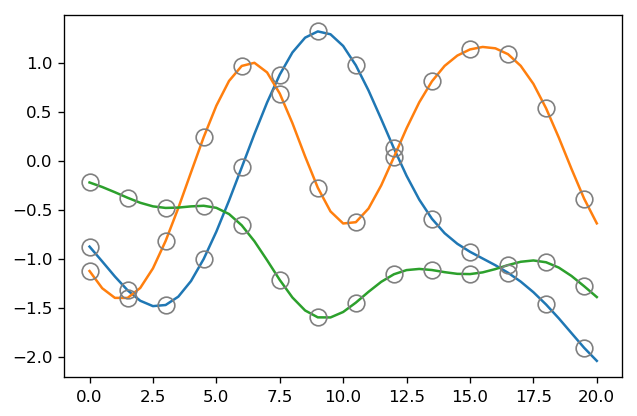

In [9]:
# gp.fit()
#toy_data_full = gp.sample_y(X_full, n_samples=n_samples, random_state=seed).T
#mean_full, cov_full = gp.predict(X_full, return_cov=True)
#The above three lines of code get replaced by something a bit more complicated when we have different GPs that we want to lump together as if they were one.
#Note that we gave up returning the covariances of the GP for which we generate the data since we decided we should not be using them.
seed=5; toy_data_full_1 = gp1.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_2 = gp2.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_3 = gp3.sample_y(X_full, n_samples=1, random_state=seed).T
#Note also that I (DP) have switched the seed after each call, to try and get GPs that start at somewhat different points. This may be unnecessary? But I hope
#it is at least not wrong. :) 


mean_full_1 = gp1.predict(X_full)
mean_full_2 = gp2.predict(X_full)
mean_full_3 = gp3.predict(X_full)

#mean = mean_full[mask]
#cov = cov_full[mask][:, mask]
#I comment out these two lines since I do not think we should be using these quantities: the code should interact with the underlying GP
#only through the toy_data, which we now generate.

toy_data_full = np.concatenate((toy_data_full_1,toy_data_full_2,toy_data_full_3),axis=0)
mean_full = np.concatenate(([mean_full_1],[mean_full_2],[mean_full_3]),axis=0)

toy_data = toy_data_full[:, mask]
X = X_full[mask]

plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');
# toy_data_full *= (ratio**orders)[:, None]

Here all three curves have same variance, even if it may not quite look like it. :)

Now if we take the data shown above, estimate the hyperparameters using conjugacy, and fit to the data, we get the plot shown below:

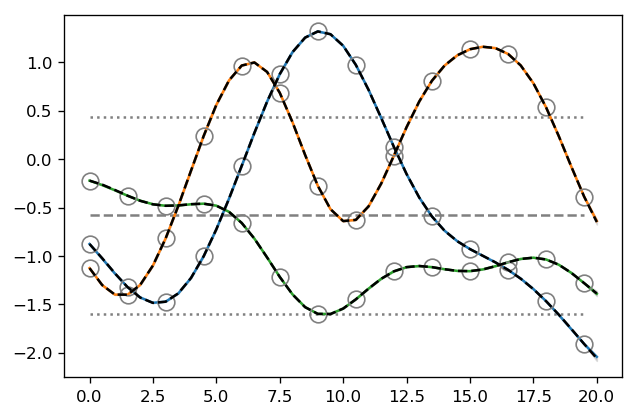

In [10]:
kernel= C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#This defines the GP for the start of the fitting. DP shifted this line
#here in order to make sure that we were not inadvertantly talking to 
#the underlying GP.

my_gp = ConjugateGaussianProcess(kernel)
my_gp.fit(X, toy_data)
X_test = X_full[~mask]
toy_data_test = toy_data_full[:, ~mask]


#compute the mean and covariance of the fitted GP at the training-set points
fitmean = my_gp.mean()
fitcov = my_gp.cov()

#compute the values of the fitted GP at all the data points on all the curves, as well as associated curve-by-curve means & covariances
X_new = X_full
# my_gp.beta()
m_pred, K_pred = my_gp.predict(X_new, return_cov=True, pred_noise=True)
m_test, K_test=my_gp.predict(X_test,return_cov=True, pred_noise=True)
# print(np.diag(K_pred))
sd_pred = np.sqrt(np.diag(K_pred))

#compute the mean and covaraince of the overall GP at the set X_full, note that a nugget should be added to fitcov_full/fitcov_test when it is used below.
fitmean_full = my_gp.mean(X_new) 
fitcov_full = my_gp.cov(X_new,X_new) 
fitmean_test = my_gp.mean(X_test) 
fitcov_test = my_gp.cov(X_test,X_test) 

# Plot the underlying process
plt.plot(X.ravel(), my_gp.mean(), ls='--', c='gray')
plt.plot(X.ravel(), my_gp.mean() + my_gp.sd(), ls=':', c='gray')
plt.plot(X.ravel(), my_gp.mean() - my_gp.sd(), ls=':', c='gray');

# Now the true data
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

# The predicted interpolants and their errors
plt.plot(X_new.ravel(), m_pred.T, c='k', ls='--', label='pred');
for m in m_pred:
    plt.fill_between(X_new.ravel(), m + 2*sd_pred, m - 2*sd_pred, color='gray', alpha=0.25)
# plt.legend();

The fits seem to interpolate in a reasonable manner. However, note that mean is significantly different to that of underlying GP. I checked that mean varies up and down between roughly -0.5 and 0.5 depending on seed. Is this variation just variance of 1 divided by 3 GPs?

Using more training points pulls the variance slightly closer to one (cf. previous version of notebook), but seems to have little effect on the mean. Mean is presumably just a consequence of these three curves being the way they are. 

Since mean & variance are estimated very similarly to previous notebook we expect B&O model checking to come out similarly, and indeed it does.

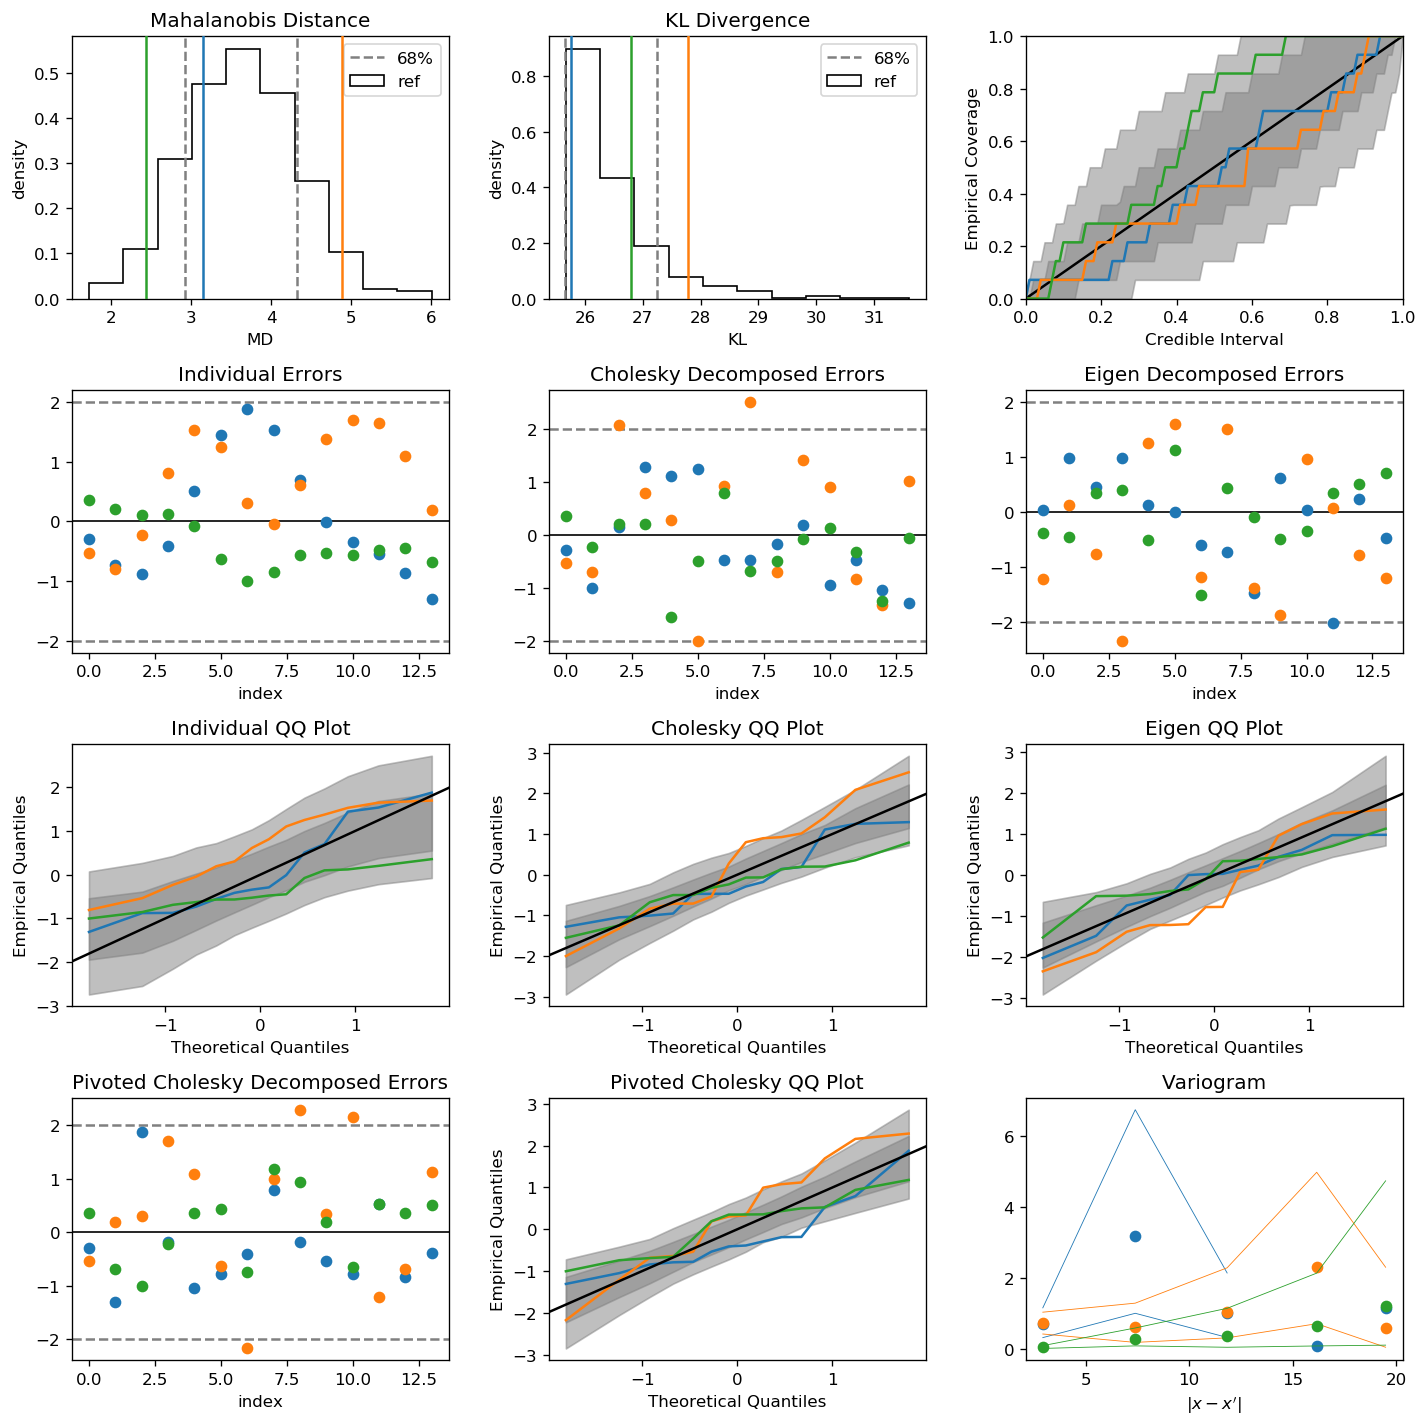

In [11]:
#First we do the diagnostics with the training data set
np.random.seed(seed)
gp = ConjugateGaussianProcess(kernel)
gpmc = Diagnostic(fitmean, fitcov)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp, vlines=vlines);

They are mostly within errors, as expected.

What if we use the test portion of the dataset?

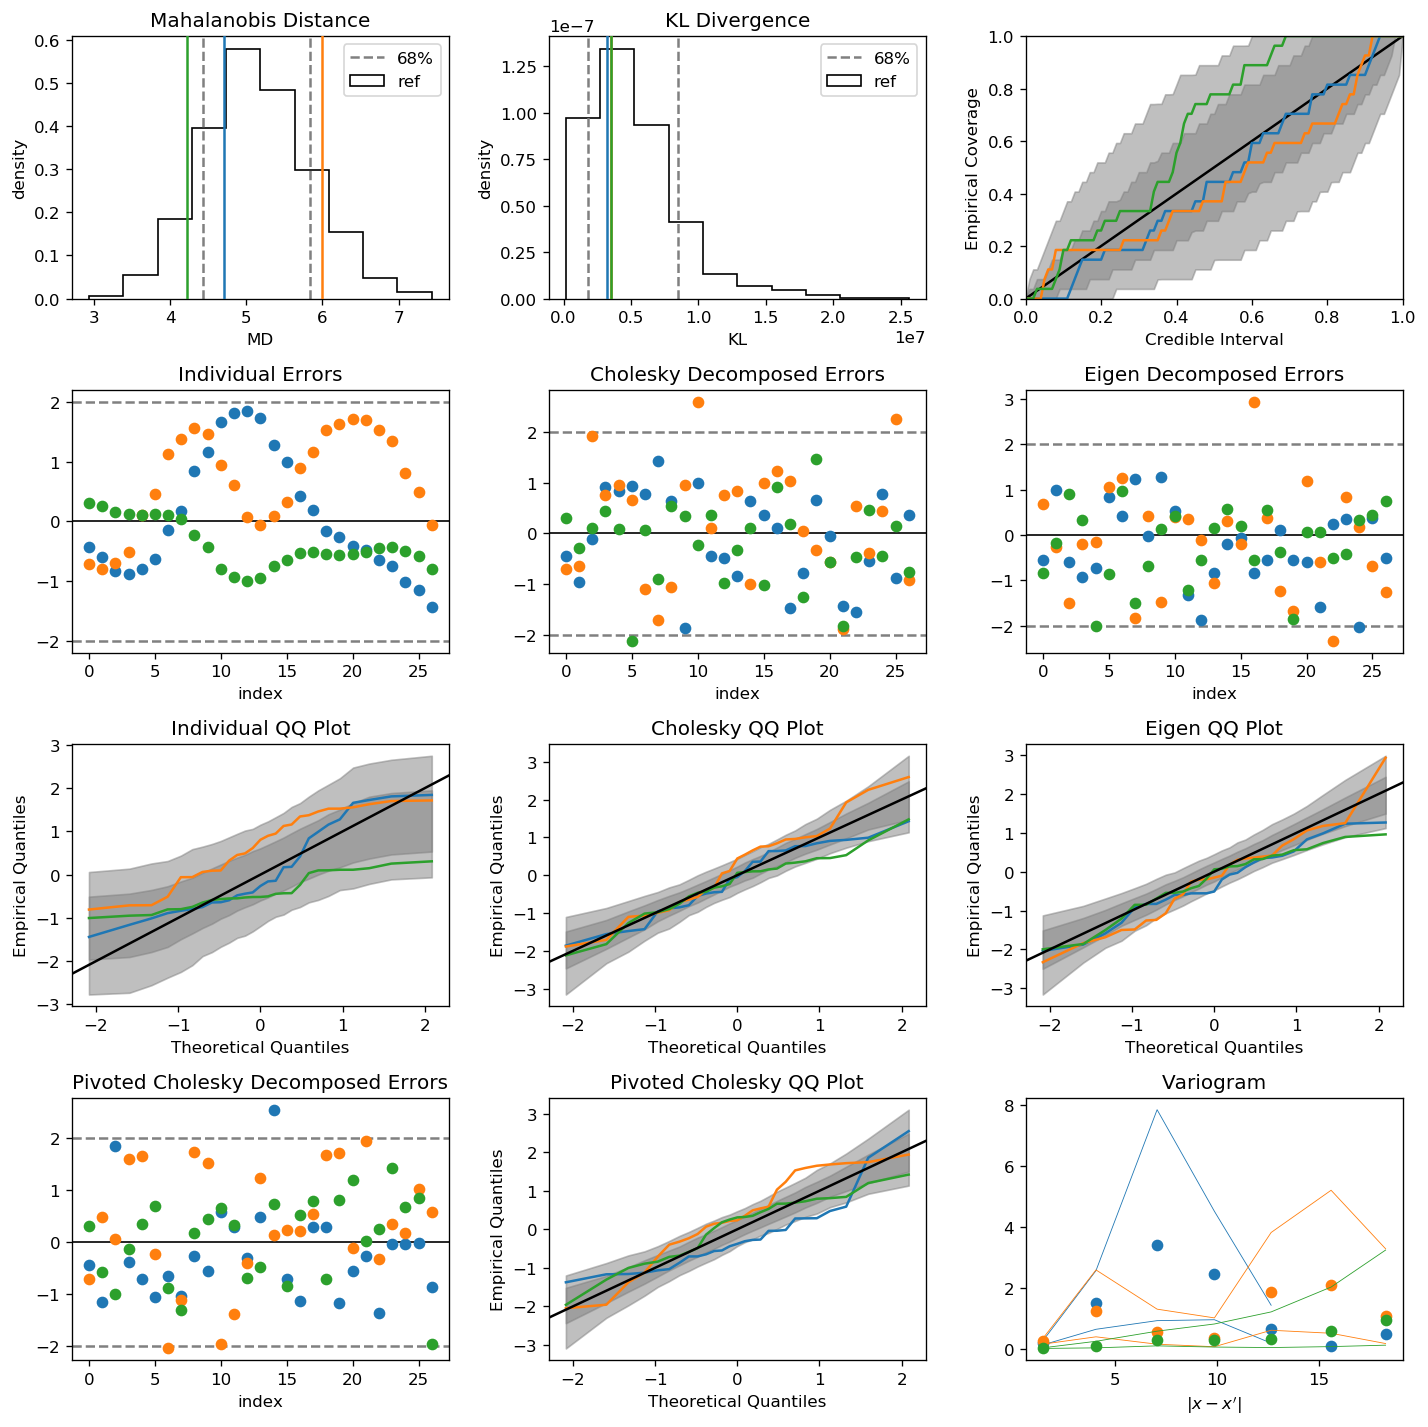

In [12]:
gp = ConjugateGaussianProcess(kernel)
gpmc_test = Diagnostic(fitmean_test, fitcov_test + nugget_sd**2 * np.eye(fitcov_test.shape[0]))
gd_test = GraphicalDiagnostic(gpmc_test, toy_data_test, nref=n_ref)
gd_test.plotzilla(X_test, gp, vlines=vlines);

Everything looks pretty good. Green MD distance is a bit too small, and phenomenon of not enoguh large green PC (or eigen) errors persists. But everything looks pretty good.

What if we performed the same model checking with the interpolants?
This time, we are comparing each colored curve to the process defined by the thin gray bands around that curve.
One potential clever way to combine the diagnostics from interpolated processes relies on the fact that the only thing that is different about the interpolating processes is their mean function that interpolates the data. If we subtract the means off the process and the data, then we are back to the simple iid case.

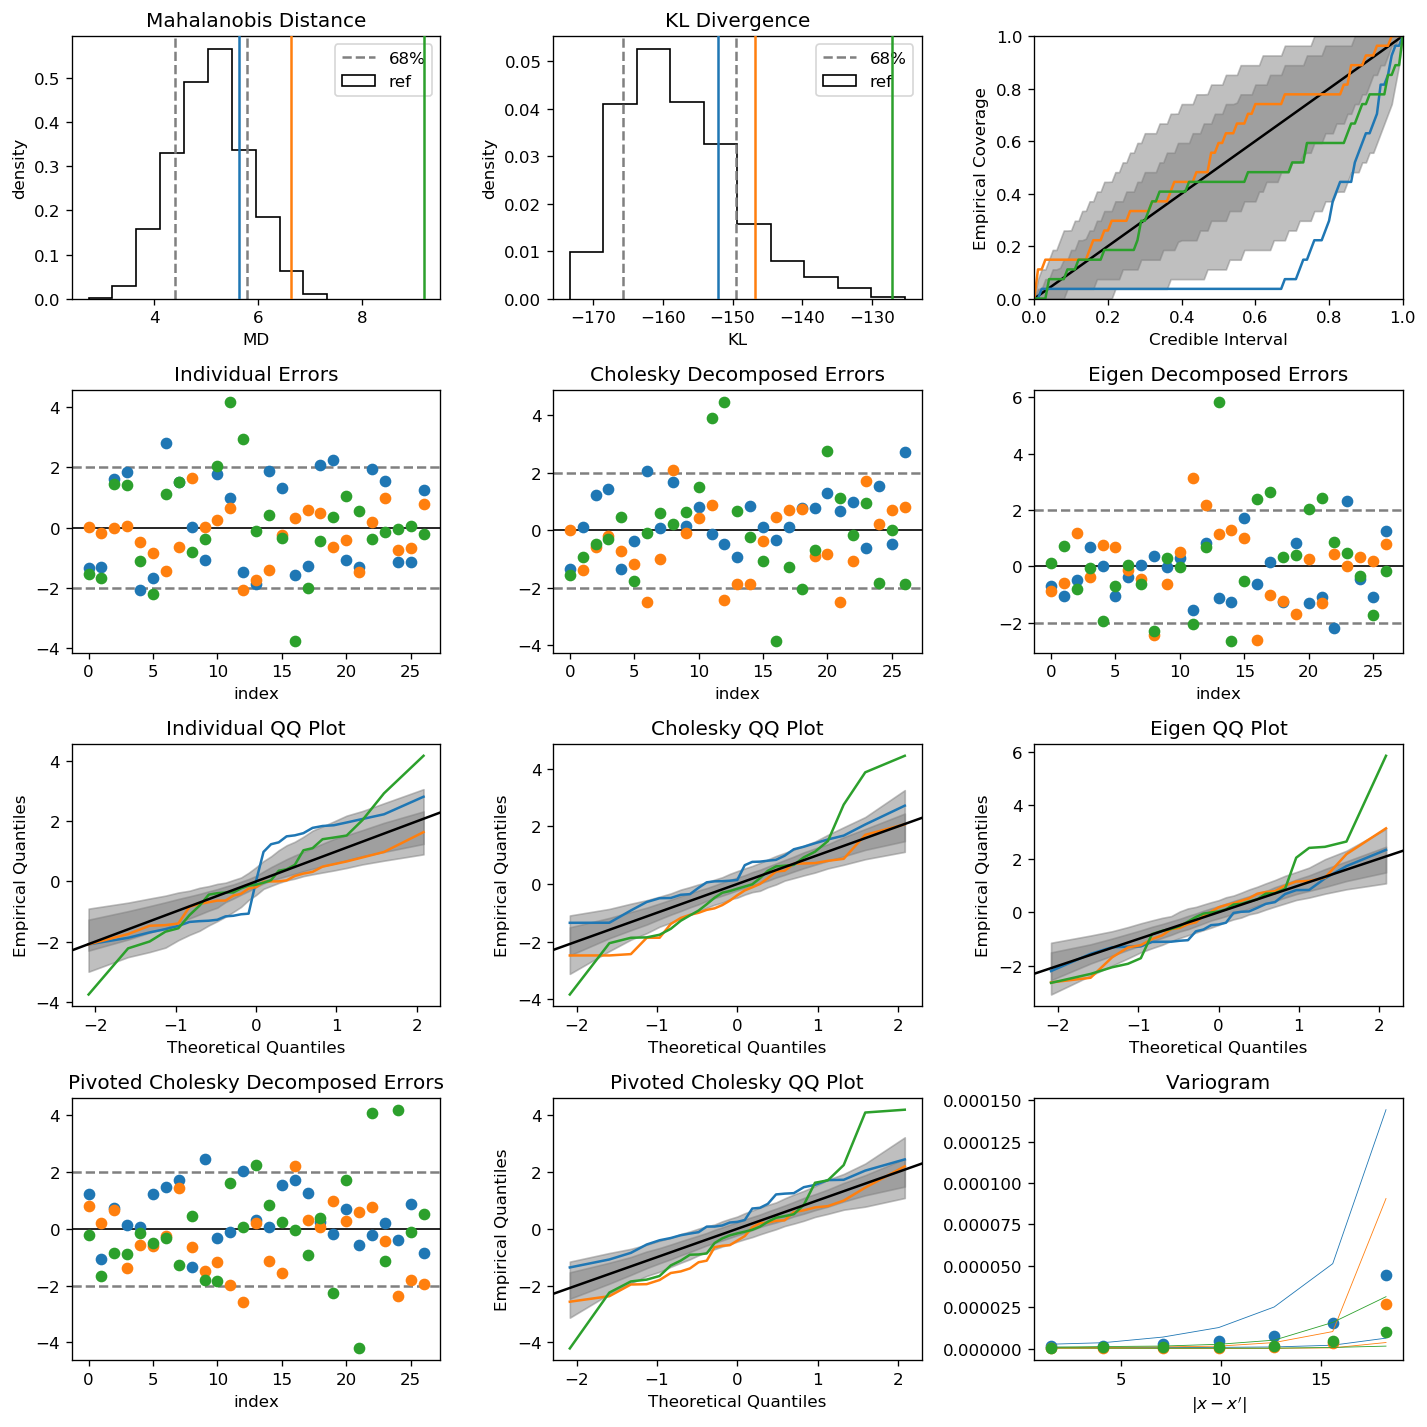

In [13]:
np.random.seed(seed)
gp = ConjugateGaussianProcess(kernel)
gp.fit(X, toy_data, noise_sd=nugget_sd)
mean_test, cov_test = gp.predict(X_test, return_cov=True, pred_noise=True)
# print(mean_est.shape)
gpmc = Diagnostic(np.zeros(mean_test.shape[1]), K_test  + nugget_sd**2 * np.eye(K_test.shape[0]))
# gpmc = GPModelChecking(np.zeros_like(mean_est[0]), cov_est, df=2*gp.a())
gd = GraphicalDiagnostic(gpmc, toy_data_test - mean_test, nref=n_ref)
gd.plotzilla(X_test, gp, predict=True, vlines=vlines);

Note that there are no longer a bunch of zeros on the PC-errors plot, because the training data has been omitted. This makes it MUCH easier to diagnose things in the DCI plot. Which then seems to indicate a problem for the blue errors. Eigen decomposed and PC decomposed errors for green  data suggest there are some problems there, and those problems are also manifest in the QQ plots. However, I must say that I can't see those issues when I just look at the performance cf. the grey bands in the figure above. Maybe "just look[ing]" in that way is analogous to computing the individual errors, which indeed look fine (except for blue). 

Note: I still do not completely understand why this and the previous diagnostic panel show different things.

## Learning the length scale

Now we will do the length-scale learning for this no-variance-shift case

In [14]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)

Setting kernel kwargs to {'ls': 3.027272727272728}


Length-scale estimation works better now that we have a finer mesh for training data.

In [15]:
Rs = np.array([rbf(X, X, ls=L) for L in ls_mesh])

ls_loglike = gp.likelihood(log=True, X=X, corr=Rs)
ls_like = np.exp(ls_loglike - np.max(ls_loglike))

ax = plt.gca()
ax.set_xlabel(r'$\ell$')
ax.set_title('Likelihood for length scale')
ax.axvline(ls_true, 0, 1, c='k')
ax.plot(ls_mesh, ls_like);

LinAlgError: singular matrix

But likelihood fails due to singular matrix. Increasing nuggest size all the way to 1e-2 does not seem to fix this. 

How will the diagnostics look now that we are closer on length scale? First, the testing set.

Setting kernel kwargs to {'ls': 3.027272727272728}


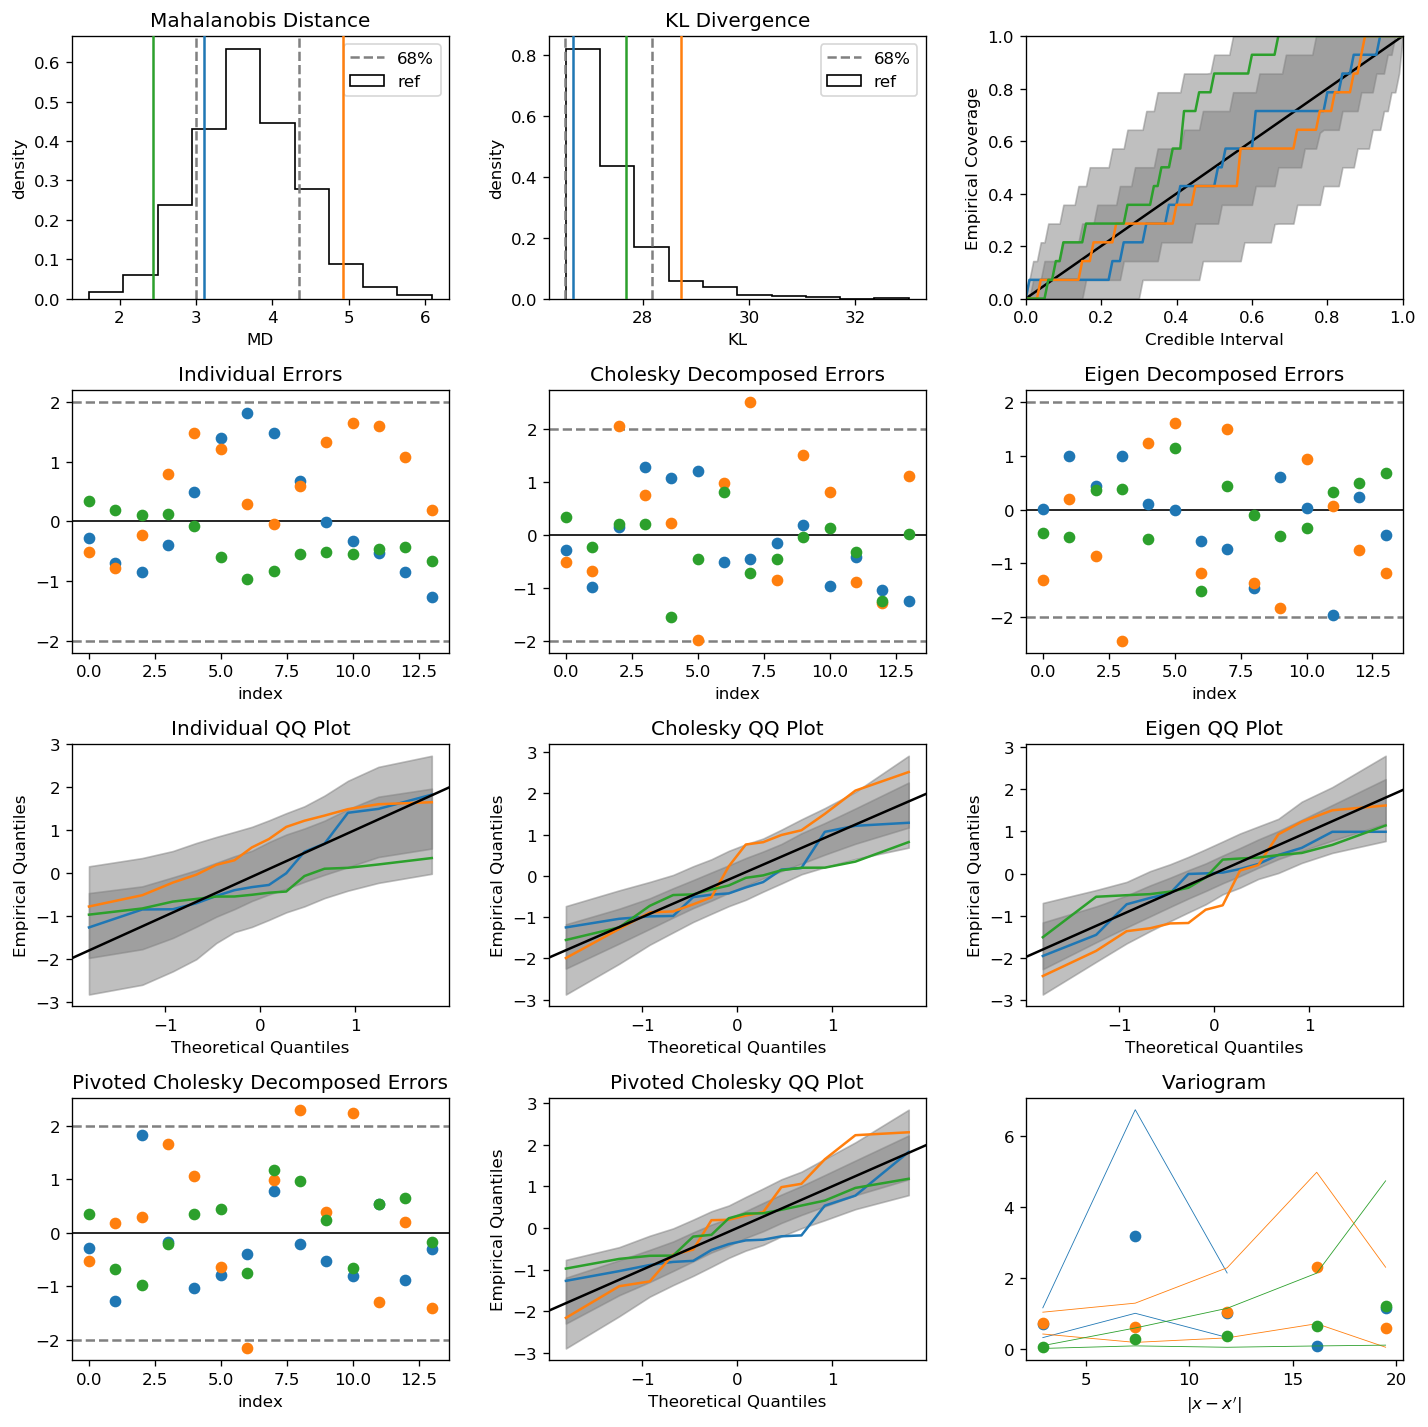

In [16]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)
best_fit = gp.kernel_kws  # These are updated by the fit

# Don't update the fit everytime you see new data, that takes too long. just use MAP values from now on
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_est, cov_est = gp.mean(), gp.cov()

gpmc = Diagnostic(mean_est, cov_est)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp_static, vlines=vlines);

Everything looks pretty good. Maybe green MD is a bit small? What about with the testing set?

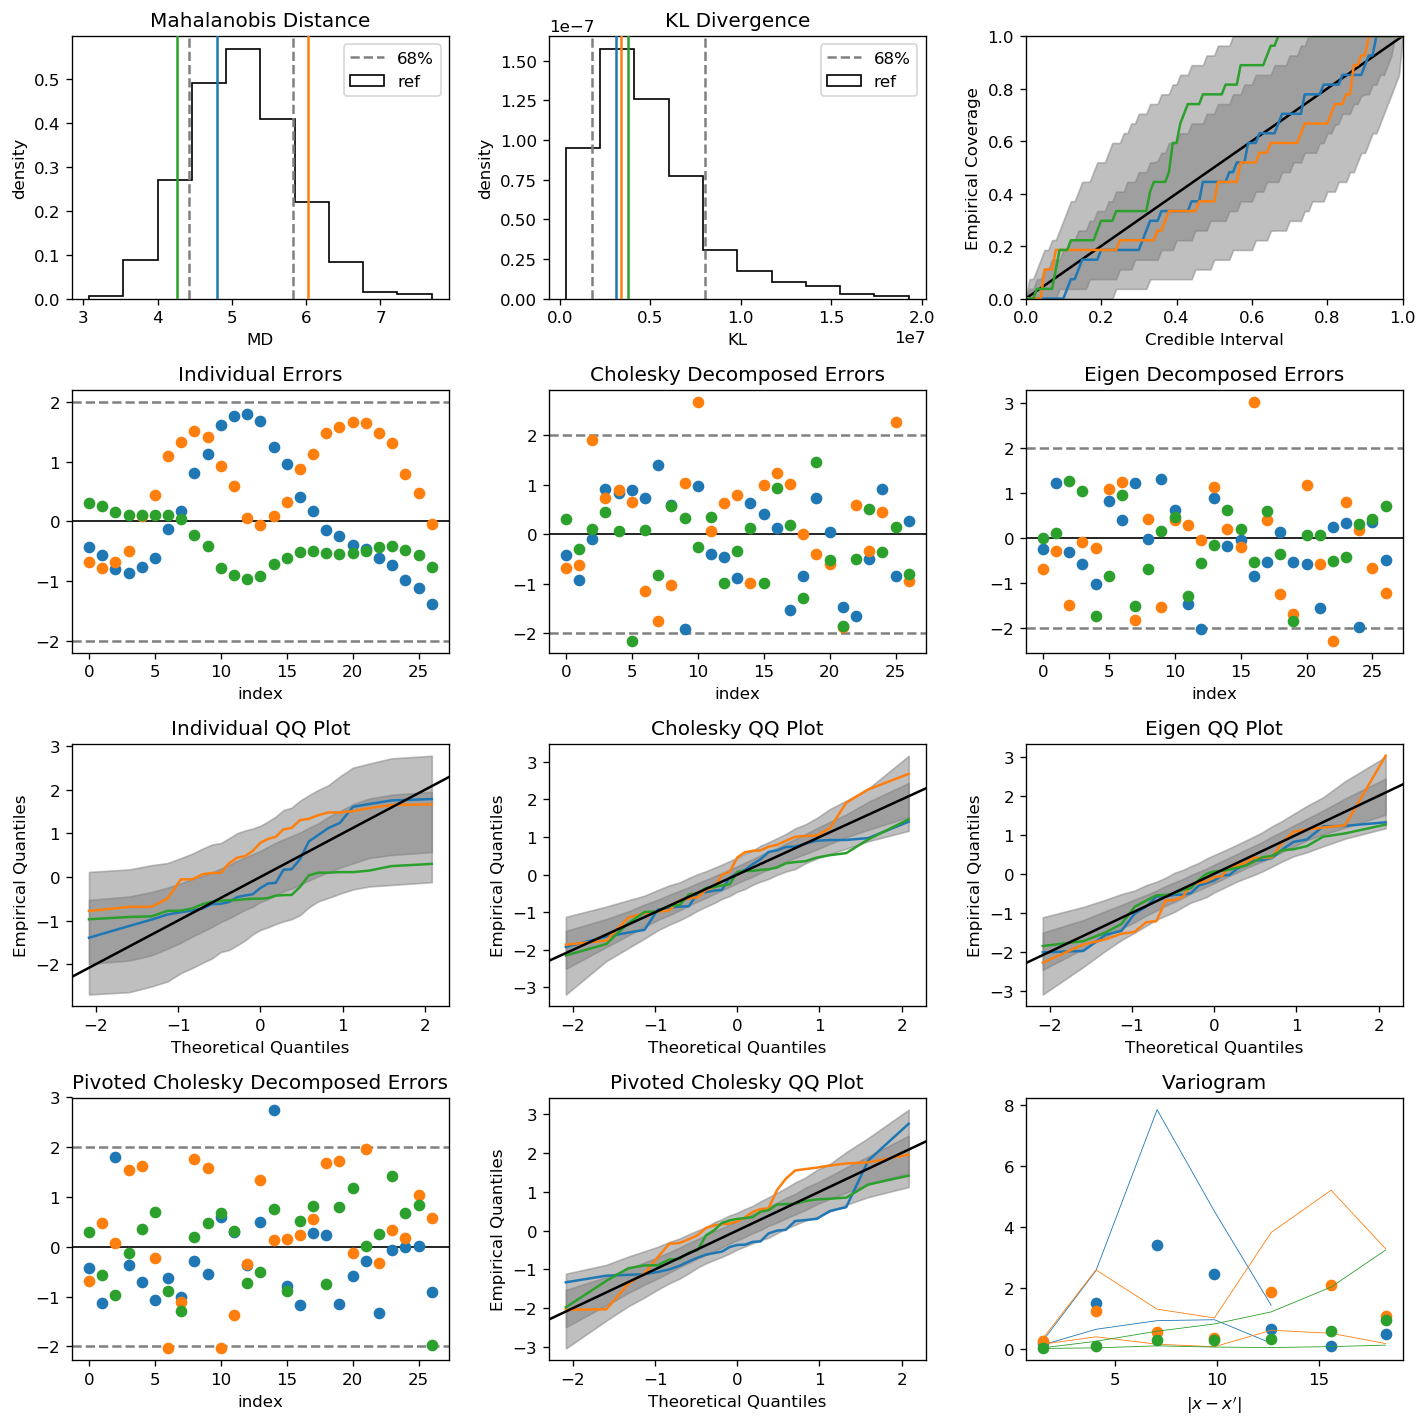

In [17]:
# Don't update the fit everytime you see new data, that takes too long. just use MAP values from now on
fitmean_test=gp.mean(X_test)
fitcov_test = gp.cov(X_test,X_test) 
gpmc_test = Diagnostic(fitmean_test, fitcov_test + nugget_sd**2 * np.eye(fitcov_test.shape[0]))
gd = GraphicalDiagnostic(gpmc_test, toy_data_test, nref=n_ref)
gd.plotzilla(X_test, gp_static, vlines=vlines);

Blue QQ plots may be a bit low, but are certainly within 1-sigma. Green MD has recovered somewhat.

Now let's check the interpolants

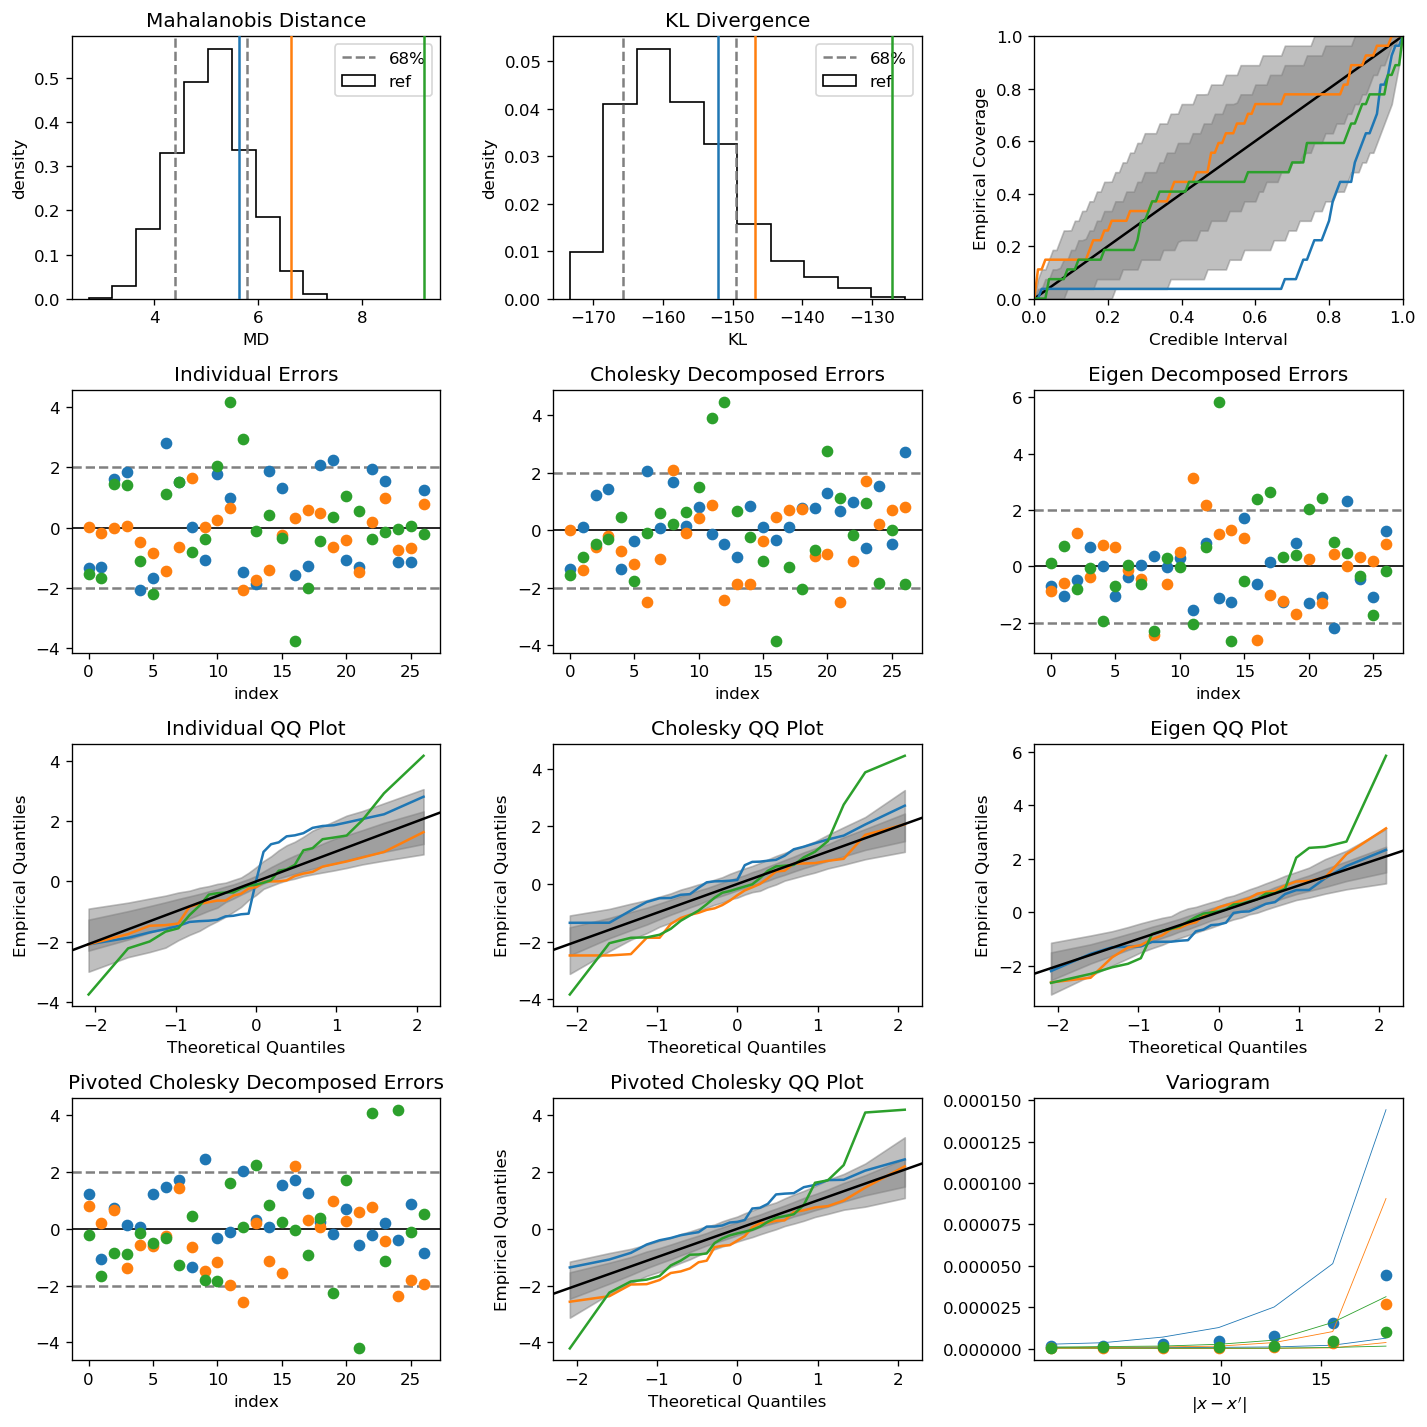

In [18]:
np.random.seed(seed)
gp = ConjugateGaussianProcess(kernel)
gp.fit(X, toy_data, noise_sd=nugget_sd)
mean_test, cov_test = gp.predict(X_test, return_cov=True, pred_noise=True)
# print(mean_est.shape)
gpmc = Diagnostic(np.zeros(mean_test.shape[1]), K_test  + nugget_sd**2 * np.eye(K_test.shape[0]))
# gpmc = GPModelChecking(np.zeros_like(mean_est[0]), cov_est, df=2*gp.a())
gd = GraphicalDiagnostic(gpmc, toy_data_test - mean_test, nref=n_ref)
gd.plotzilla(X_test, gp, predict=True, vlines=vlines);

Everything looks pretty good. And reassuringly similar to above plots. Not surprising given how close length scale came out. 

## Baseline with a second noise realization
Does the improvement in length-scale estimation persist if we take a different noise?

In [19]:
basevariance=1.0; varianceshiftfactor=1; baselengthscale=3; lengthscaleshift=0

In [20]:
shiftvarup_kernel=C(basevariance*varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
shiftvardown_kernel=C(basevariance/varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthup_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale+lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthdown_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale-lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#kernel = true_kernel

# Whether or not vertical lines or a histogram is plotted for the md and kl plots
vlines = True

gp1 = GaussianProcessRegressor(kernel=true_kernel, n_restarts_optimizer=9, optimizer=None,)
gp2 = GaussianProcessRegressor(kernel=shiftvarup_kernel,n_restarts_optimizer=9, optimizer=None)
gp3 = GaussianProcessRegressor(kernel=shiftvardown_kernel,n_restarts_optimizer=9, optimizer=None)

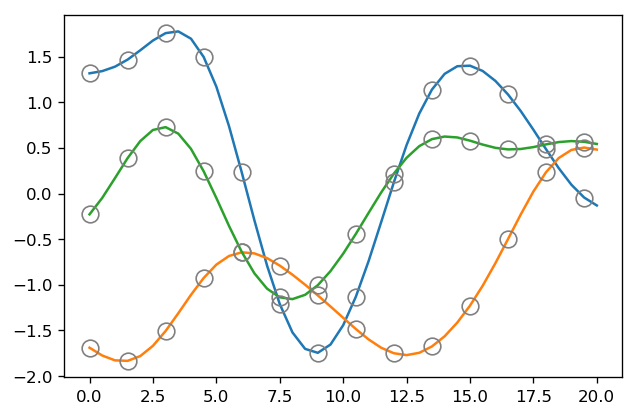

In [21]:
# gp.fit()
#toy_data_full = gp.sample_y(X_full, n_samples=n_samples, random_state=seed).T
#mean_full, cov_full = gp.predict(X_full, return_cov=True)
#The above three lines of code get replaced by something a bit more complicated when we have different GPs that we want to lump together as if they were one.
#Note that we gave up returning the covariances of the GP for which we generate the data since we decided we should not be using them.
seed=2; toy_data_full_1 = gp1.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_2 = gp2.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_3 = gp3.sample_y(X_full, n_samples=1, random_state=seed).T
#Note also that I (DP) have switched the seed after each call, to try and get GPs that start at somewhat different points. This may be unnecessary? But I hope
#it is at least not wrong. :) 


mean_full_1 = gp1.predict(X_full)
mean_full_2 = gp2.predict(X_full)
mean_full_3 = gp3.predict(X_full)

#mean = mean_full[mask]
#cov = cov_full[mask][:, mask]
#I comment out these two lines since I do not think we should be using these quantities: the code should interact with the underlying GP
#only through the toy_data, which we now generate.

toy_data_full = np.concatenate((toy_data_full_1,toy_data_full_2,toy_data_full_3),axis=0)
mean_full = np.concatenate(([mean_full_1],[mean_full_2],[mean_full_3]),axis=0)

toy_data = toy_data_full[:, mask]
X = X_full[mask]

plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');
# toy_data_full *= (ratio**orders)[:, None]

Again, all three curves have same variance.

Now if we take the data shown above, estimate the hyperparameters using conjugacy, and fit to the data, we get the plot shown below:

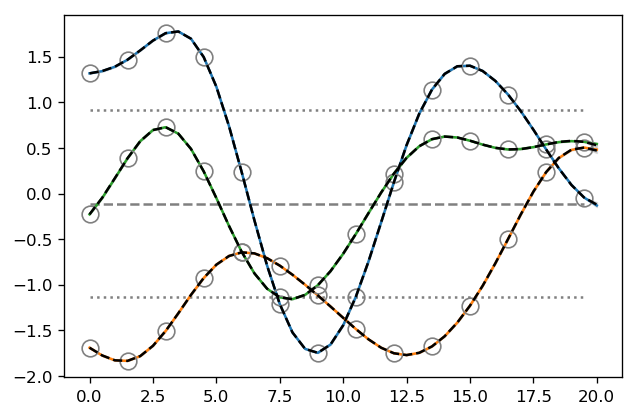

In [22]:
kernel= C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#This defines the GP for the start of the fitting. DP shifted this line
#here in order to make sure that we were not inadvertantly talking to 
#the underlying GP.

my_gp = ConjugateGaussianProcess(kernel)
my_gp.fit(X, toy_data)
X_test = X_full[~mask]
toy_data_test = toy_data_full[:, ~mask]


#compute the mean and covariance of the fitted GP at the training-set points
fitmean = my_gp.mean()
fitcov = my_gp.cov()

#compute the values of the fitted GP at all the data points on all the curves, as well as associated curve-by-curve means & covariances
X_new = X_full
# my_gp.beta()
m_pred, K_pred = my_gp.predict(X_new, return_cov=True, pred_noise=True)
m_test, K_test=my_gp.predict(X_test,return_cov=True, pred_noise=True)
# print(np.diag(K_pred))
sd_pred = np.sqrt(np.diag(K_pred))

#compute the mean and covaraince of the overall GP at the set X_full, note that a nugget should be added to fitcov_full/fitcov_test when it is used below.
fitmean_full = my_gp.mean(X_new) 
fitcov_full = my_gp.cov(X_new,X_new) 
fitmean_test = my_gp.mean(X_test)
fitcov_test=my_gp.cov(X_test)

# Plot the underlying process
plt.plot(X.ravel(), my_gp.mean(), ls='--', c='gray')
plt.plot(X.ravel(), my_gp.mean() + my_gp.sd(), ls=':', c='gray')
plt.plot(X.ravel(), my_gp.mean() - my_gp.sd(), ls=':', c='gray');

# Now the true data
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

# The predicted interpolants and their errors
plt.plot(X_new.ravel(), m_pred.T, c='k', ls='--', label='pred');
for m in m_pred:
    plt.fill_between(X_new.ravel(), m + 2*sd_pred, m - 2*sd_pred, color='gray', alpha=0.25)
# plt.legend();

The fits seem to interpolate in a reasonable manner. This time mean is close to zero and variance is close to one. This result is very similar to that obtained with fewer training points. So we will postpone the B&O diagnostics until after we've done length-scale estimation. 

## Learning the length scale: baseline with different noise

In [23]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)

Setting kernel kwargs to {'ls': 3.027272727272728}


The length scale seeems to come out exactly the same as with the different seed: in spite of the fact that the data looks quite different. Is this coincidence? It certainly didn't happen before when we had less training data and wound up on either side of the true length scale for different seeds. 

How will the diagnostics look now?

Setting kernel kwargs to {'ls': 3.027272727272728}


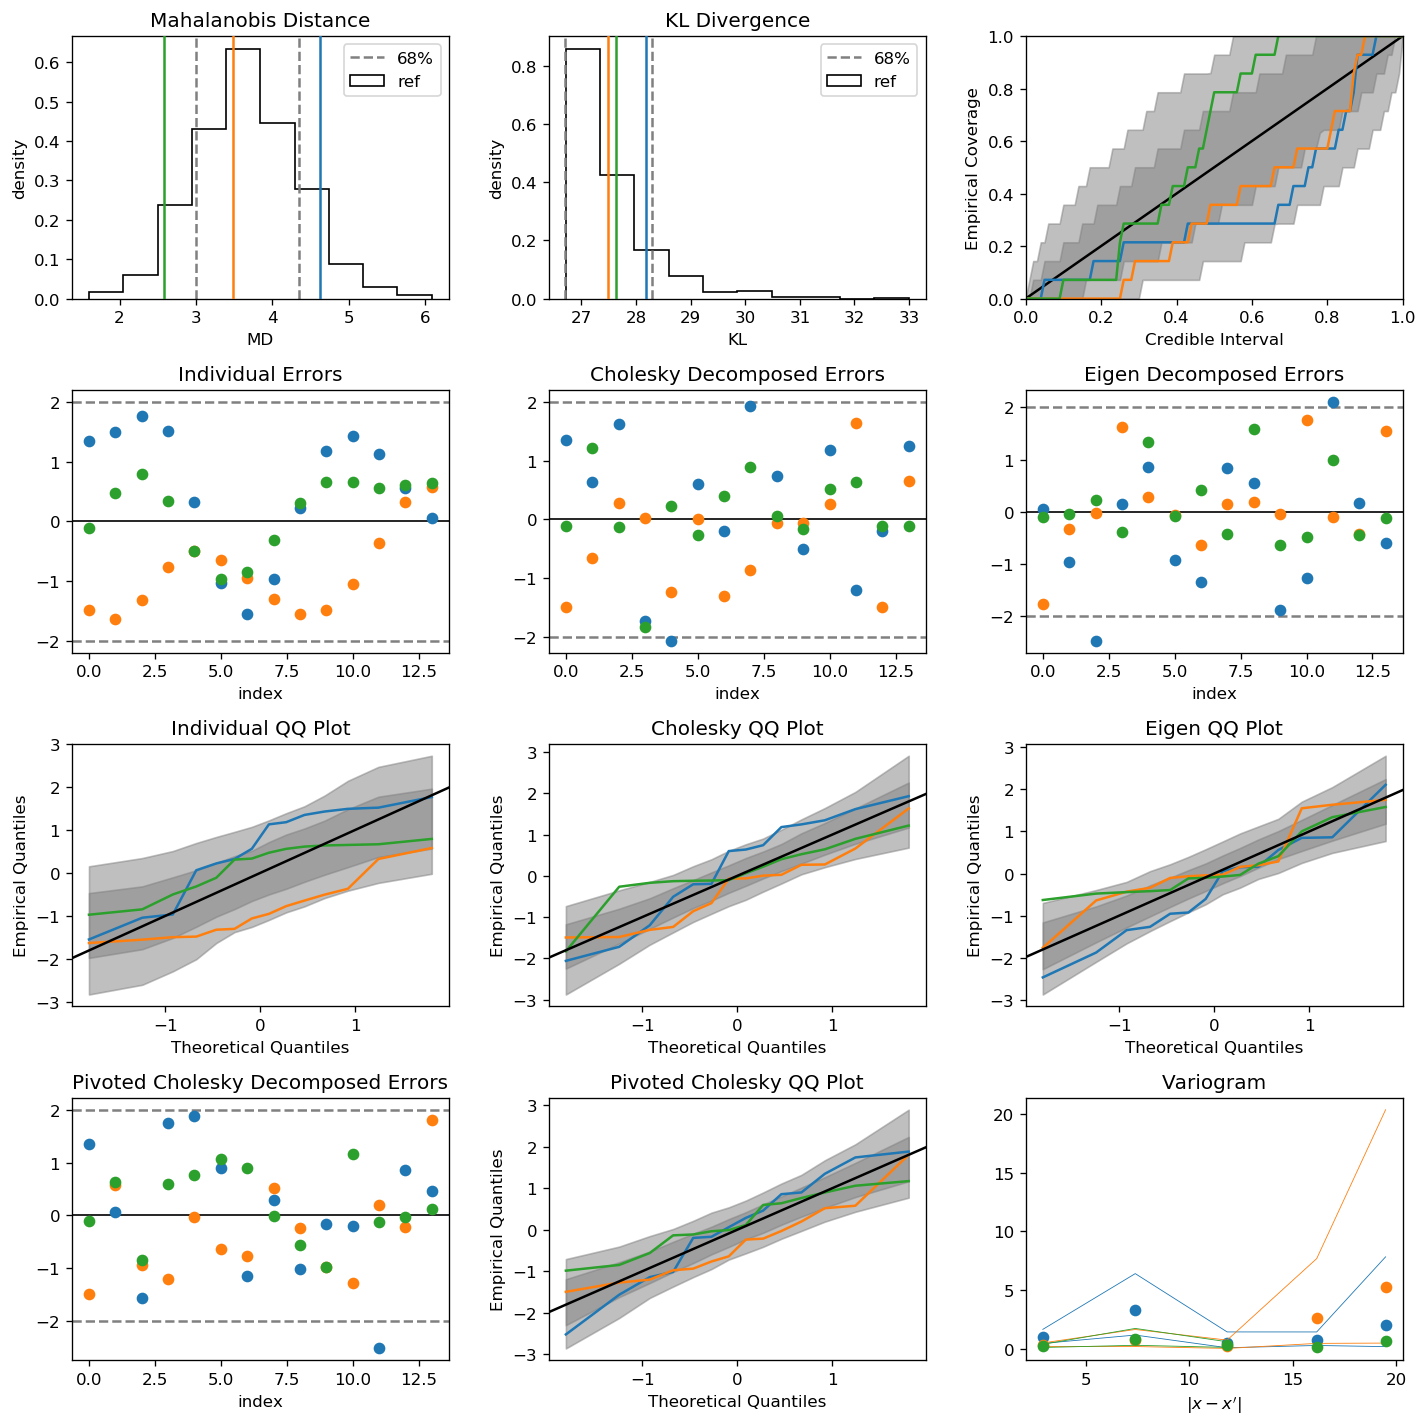

In [24]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)
best_fit = gp.kernel_kws  # These are updated by the fit

# Don't update the fit everytime you see new data, that takes too long. just use MAP values from now on
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_est, cov_est = gp.mean(), gp.cov()

gpmc = Diagnostic(mean_est, cov_est)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp_static, vlines=vlines);

Green PC errors are too small, its QQ plot has wrong slope. Consequently MD for green is marginally too small.

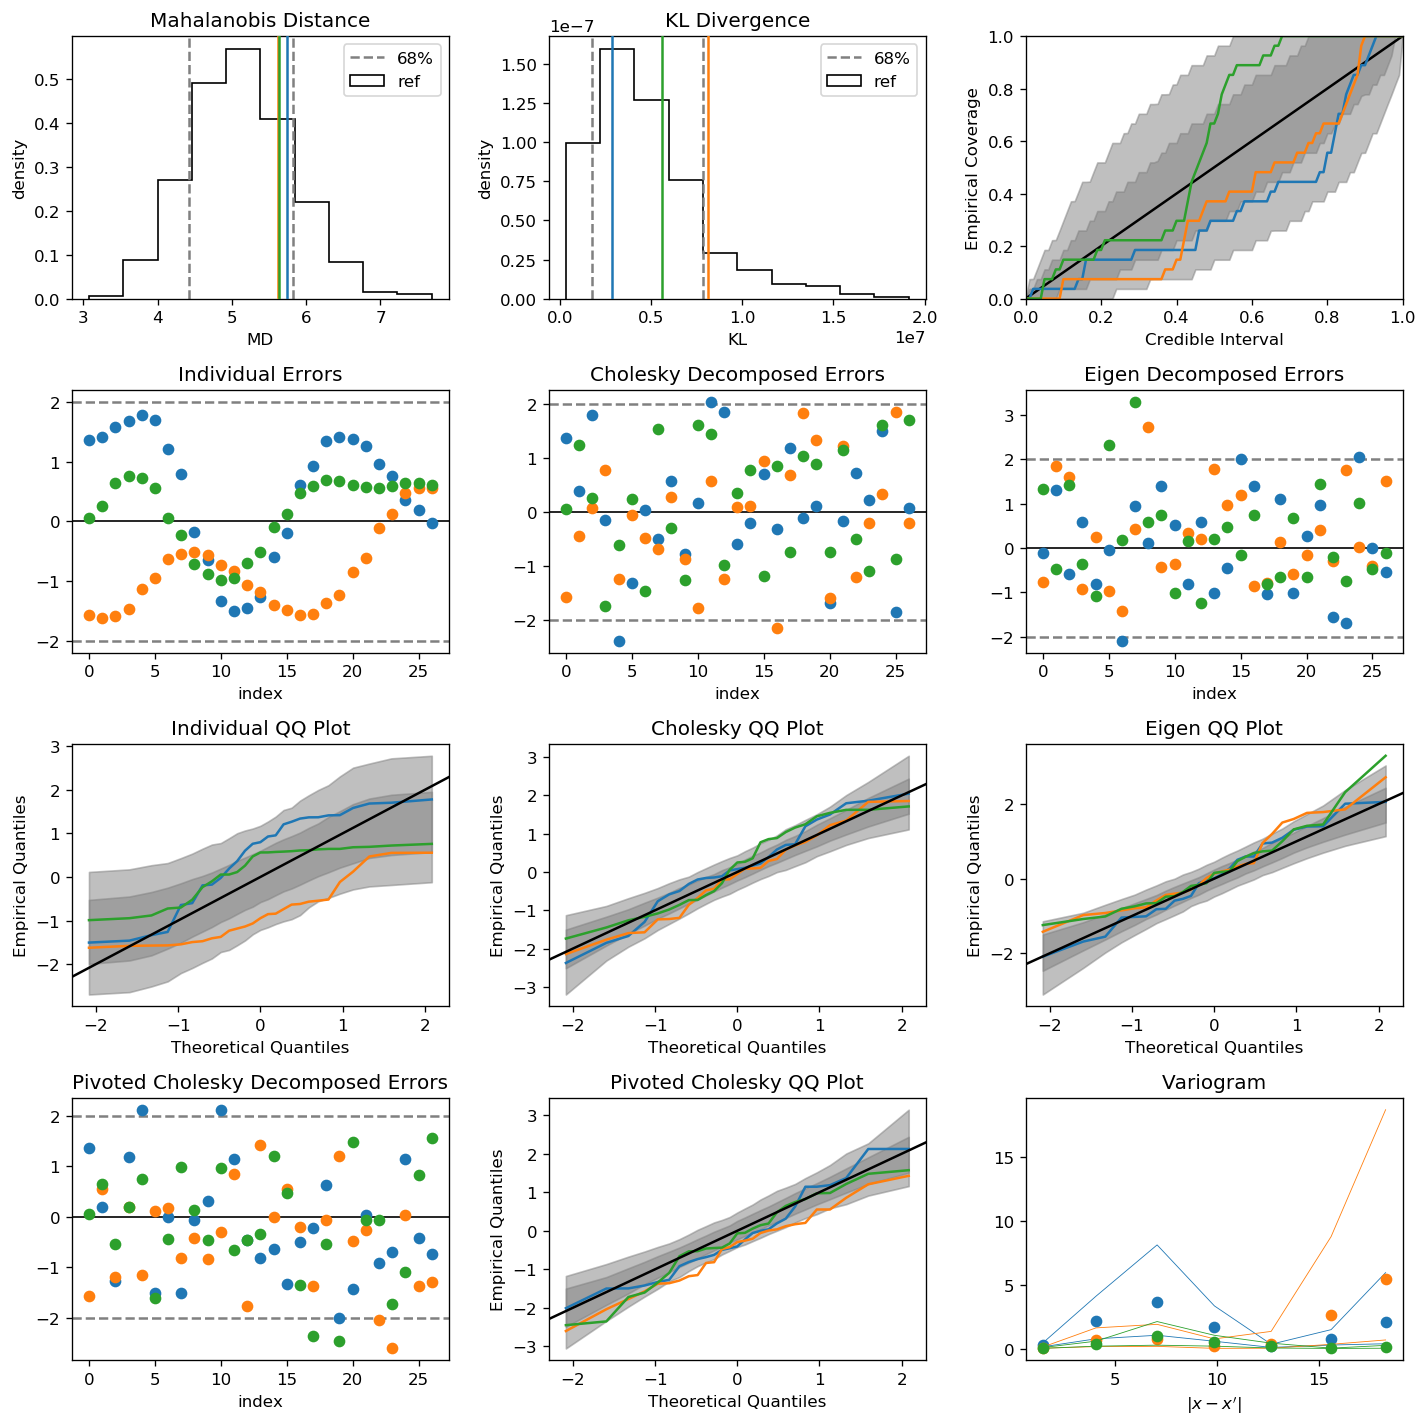

In [25]:
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
fitmean_test =gp.mean(X_test) 
fitcov_test = gp.cov(X_test,X_test) 

gpmc_test = Diagnostic(fitmean_test, fitcov_test + nugget_sd**2 * np.eye(fitcov_test.shape[0]))
gd_test = GraphicalDiagnostic(gpmc_test, toy_data_test, nref=n_ref)
gd_test.plotzilla(X_test, gp_static, vlines=vlines);

Everything is awesome for blue & green and orange is okay. But where is the orange MD? Now the interpolants.

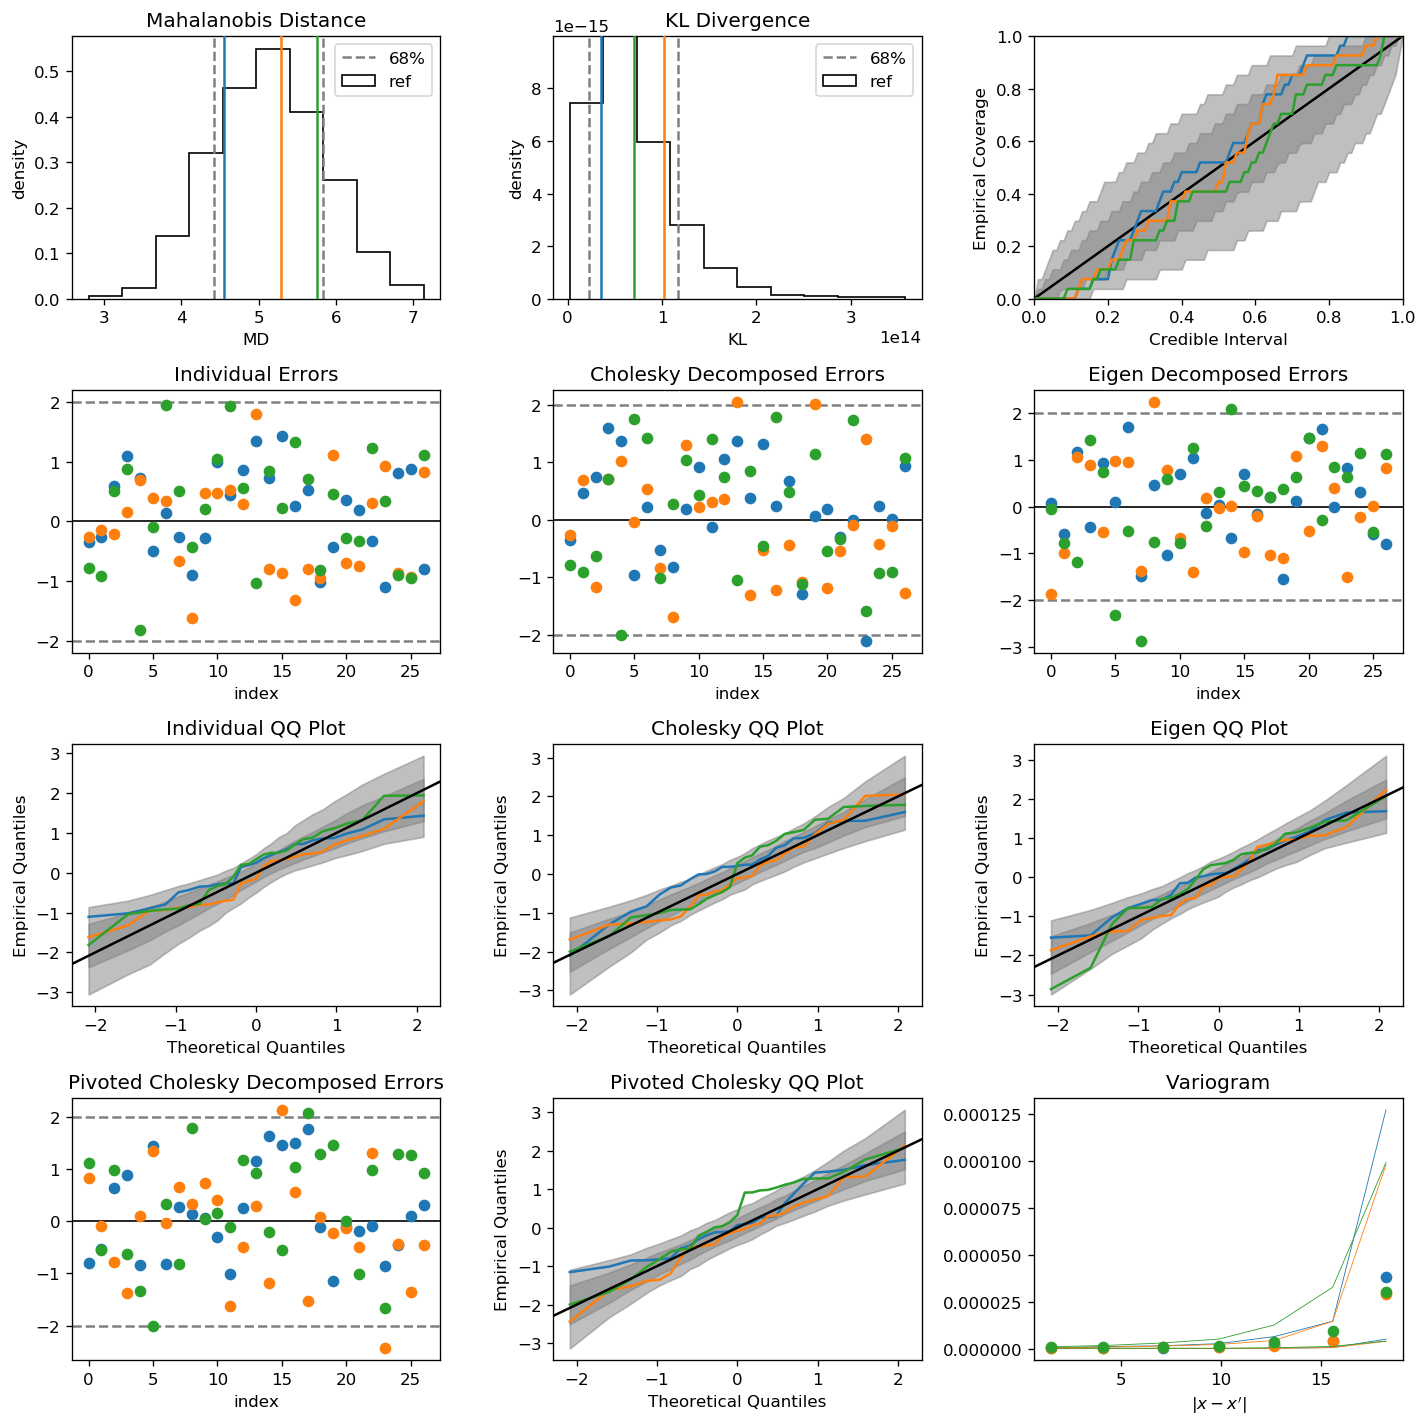

In [26]:
mean_test, cov_test = gp.predict(X_test, return_cov=True, pred_noise=True)

gpmc = Diagnostic(np.zeros(mean_test.shape[1]), cov_test)
gd = GraphicalDiagnostic(gpmc, toy_data_test-mean_test, nref=n_ref)
gd.plotzilla(X_test, gp_static, vlines=vlines);

Interpolants also look good.